## Code to read the files

In [1]:
import pandas as pd
import numpy as np
import gzip
import time
import os, sys, time
import collections
from collections import Counter
import json
import random

In [2]:
#Read product metadata
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

dfMeta = getDF('meta_Toys_and_Games.json.gz')
#Pull out the subcategory for the products from the categories field.
dfMeta['subCateg'] = dfMeta['categories'].map(lambda x:x[0][1] if len(x[0]) > 1 else x[0][0])

In [4]:
#Read text based product features
dfTextF = pd.read_csv('product_features.tar.gz',compression = 'gzip')
dfTextF.rename(columns = {'product_features.0.csv':'asin'," 'note'":'feature'}, inplace = True)

In [5]:
#Read title and description based features
product_attribute_features_filepath = './product_attribute_features.harvested.0.csv'
with open('product_attribute_features.harvested.0.csv', mode='r') as in_f:
   productTitleDescFeatures = pd.read_csv(in_f, names=['asin','overall','feature'])
   print('File {} contains {} total product features.'.format(product_attribute_features_filepath,
                                                              len(productTitleDescFeatures)))
   print(productTitleDescFeatures[:10])

File ./product_attribute_features.harvested.0.csv contains 13105 total product features.
         asin   overall      feature
0  0439893577  4.352941   chalkboard
1  0439893577  4.352941   activities
2  0439893577  4.352941     tabletop
3  0439893577  4.352941     everyone
4  0615444172  5.000000      drawing
5  0615444172  5.000000      animals
6  0735333483  4.400000         farm
7  0786955708  3.818182         land
8  0786959916  4.648649         lord
9  0786964502  4.666667    expansion


In [6]:
#Read MF based similar products
with open('neighbors5.json', 'r') as f_:
     data = json.load(f_)
df = pd.DataFrame(data.items(), columns=['item', 'similar'])

In [7]:
#Code to get the recommended items given a list of user items asins, based on text features of the items.
def findSimilarsText(userItems): 
    
    userCategories = np.unique(dfMeta[dfMeta['asin'].isin(userItems)]['subCateg'].reset_index(drop = True))
    print(userCategories)
    
    similarItems = []
    
    #Find all items with at least one feature in common with the user selected item features
    for item in userItems:
        reviewFeatures = dfTextF[dfTextF['asin'] == item]['feature'].to_list()
#         print(reviewFeatures)
        for feature in reviewFeatures:
            simProds = dfTextF[dfTextF['feature'] == feature]['asin'].to_list()
            print(feature,len(simProds))
            for prod in simProds:
                if prod != item:
                    similarItems.append(prod)


        titleDescFeatures = productTitleDescFeatures[productTitleDescFeatures['asin'] == item]['feature'].to_list()
        for feature in titleDescFeatures:
            simProds = productTitleDescFeatures[productTitleDescFeatures['feature'] == feature]['asin'].to_list()
            print(feature,len(simProds))
            for prod in simProds:
                if prod != item:
                    similarItems.append(prod)
                
    temp = dfMeta[dfMeta['asin'].isin(similarItems)]
    print('subCategories',Counter(temp['subCateg']))
    selectSimilarItems = temp[temp['subCateg'].isin(userCategories)]['asin'].reset_index(drop = True)
    a = Counter(selectSimilarItems) #Items limited to same subcategory as user picked items
    b = Counter(similarItems) #All similar items irrespective of category
    print('Number of items before and after limiting categories',len(b),len(a))
    
    recommendedItems = []
    for asin,count in a.most_common(4):
        recommendedItems.append(asin)
    for asin,count in b.most_common(2):
        recommendedItems.append(asin)
    
    return recommendedItems  

In [10]:
#Sample code to call the function

#Picking a couple of random items. In actual engine, the user items would be passed into the function call and this would not be needed

numSelections = 2
prodList = dfTextF.groupby('asin').agg('count').index.to_list()
userItems = random.sample(prodList, numSelections) 
print(userItems)
print("""""")

#Sample function call
simItemsList = findSimilarsText(userItems)
simItemsList

['B001W30E14', 'B00B909ZNS']

['Dress Up & Pretend Play' 'Electronics for Kids']
 'a+ book' 242
 'tag reader' 25
 'tag' 35
 story 27
 'kmart' 53
 'price' 663
 'makeup' 13
subCategories Counter({'Electronics for Kids': 127, 'Dolls & Accessories': 118, 'Action Figures & Statues': 97, 'Arts & Crafts': 93, 'Building Toys': 71, 'Learning & Education': 67, 'Stuffed Animals & Plush': 65, 'Dress Up & Pretend Play': 56, 'Sports & Outdoor Play': 54, 'Toy Remote Control & Play Vehicles': 50, 'Games': 42, 'Toys & Games': 29, 'Baby & Toddler Toys': 26, 'Party Supplies': 22, 'Novelty & Gag Toys': 21, 'Puzzles': 19, 'Hobbies': 17, 'Grown-Up Toys': 12, 'Tricycles, Scooters & Wagons': 6})
Number of items before and after limiting categories 992 183


['0976990709',
 'B00000J05S',
 'B00003GPTI',
 'B00004TBFB',
 'B00134PLT2',
 'B00134O9MC']

In [16]:
#Function to create recommendations based on MF-based similarity to all items in userItems (list of asins picked by user)

def findSimilarsMF(userItems):
    userCategories = np.unique(dfMeta[dfMeta['asin'].isin(userItems)]['subCateg'].reset_index(drop = True))
    similarItems = []
    
    similarItemsDf = df[df['item'].isin(userItems)]['similar'].reset_index(drop = True)
#     similarItems = [item for sublist in similarItemsDf for item in sublist]
    for i in range(similarItemsDf.shape[0]):
        for item in similarItemsDf[i]:
            similarItems.append(item)
#     print(len(similarItems),similarItems)
    
    for uItem in userItems:
        similarItems = [x for x in similarItems if x != uItem]
        
    temp = dfMeta[dfMeta['asin'].isin(similarItems)]
#     print('subCategories',Counter(temp['subCateg']))
    selectSimilarItems = temp[temp['subCateg'].isin(userCategories)]['asin'].reset_index(drop = True)
    
    a = Counter(selectSimilarItems) #Items limited to same subcategory as user picked items
    b = Counter(similarItems) #All similar items irrespective of category
    
    recommendedItems = []
    for asin,count in a.most_common(4):
        recommendedItems.append(asin)
    for asin,count in b.most_common(2):
        recommendedItems.append(asin)
    
    return recommendedItems

In [20]:
#Sample function call to get MF based recommendations
simItemsListMF = findSimilarsMF(userItems)
simItemsListMF

['0735333483',
 'B0012K3H52',
 'B0019IF8ZO',
 'B001WRSER6',
 'B00404ZUMU',
 'B008HA08QQ']

### Code to show the output of recommendations

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import requests
from io import BytesIO

def showImages(images):
    imageswidth = len(images)*4
    fig=plt.figure(figsize=(imageswidth, 8))

    for i in range(0,len(images)):
        response = requests.get(images[i])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(img)

,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
192983,B004MWJLFC,,LeapFrog Peek-A-Shoe Octopus,42.59,{'Toys & Games': 88859},http://ecx.images-amazon.com/images/I/41tWx9bL...,LeapFrog Enterprises,"[[Toys & Games, Electronics for Kids, Electron...","{'also_bought': ['B004MWN0G8', 'B00DCWM2Z4', '...",Electronics for Kids
193070,B004MYH0DA,Cars 2 Bomb Blastin' Mater: Inspired by the ne...,Cars 2 Bomb Blastin' Mater,24.63,{'Toys & Games': 18675},http://ecx.images-amazon.com/images/I/51uIc71B...,Mattel,"[[Toys & Games, Toy Remote Control & Play Vehi...","{'also_bought': ['B004H4XLRY', 'B00C18BXM8', '...",Toy Remote Control & Play Vehicles


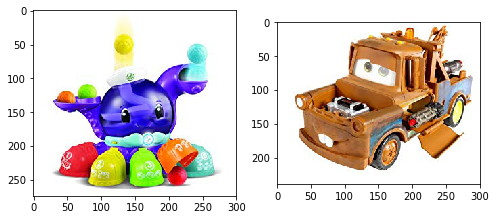

In [27]:
#Pick some user items randomly to find similar products for
numSelections = 2 #This can be varied based on how long we want the user list to be.
prodList = dfTextF.groupby('asin').agg('count').index.to_list()
userItems = random.sample(prodList, numSelections)

#Show user items picked
images = dfMeta[dfMeta['asin'].isin(userItems)]['imUrl'].to_list()
showImages(images)
dfMeta[dfMeta['asin'].isin(userItems)]

,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
142,0735308365,Children and adults enjoy Clare Beaton's fun i...,Animal ABC's Ring Flash Cards,7.52,{'Toys & Games': 8337},http://ecx.images-amazon.com/images/I/41TKptgt...,Mudpuppy,"[[Toys & Games, Learning & Education, Flash Ca...","{'also_bought': ['0735334188', '0735331006', '...",Learning & Education
238,0735333483,Each colorful wooden magnet is a barnyard anim...,On the Farm Wooden Magnetic Shapes (Set of Thi...,11.59,{'Toys & Games': 18865},http://ecx.images-amazon.com/images/I/41FCzK4O...,Mudpuppy,"[[Toys & Games, Learning & Education, Early De...","{'also_bought': ['0735333491', '0735336423', '...",Learning & Education
315,074242720X,Grade K-1. Includes both sets of lowercase and...,Ideal School Supply Tactile Letters Kit,10.60,{'Toys & Games': 6039},http://ecx.images-amazon.com/images/I/31ZJzr6N...,Ideal School Supply,"[[Toys & Games, Learning & Education, Basic & ...","{'also_bought': ['B002DG50FY', '1419704117', '...",Learning & Education
1417,1591747775,# Reading level: Ages 4-8 # Spiral-bound: 50 p...,Lego Crazy Action Contraptions Kit by Klutz,9.99,{'Toys & Games': 8825},http://ecx.images-amazon.com/images/I/51nrrQOK...,Klutz,"[[Toys & Games, Building Toys, Building Sets]]","{'also_bought': ['B00EDQDGFI', 'B00CIXVITO', '...",Building Toys
2099,1932188126,The Anagram game that will drive you bananas. ...,Bananagrams,12.46,{'Toys & Games': 119},http://ecx.images-amazon.com/images/I/51bcoyUh...,Bananagrams,"[[Toys & Games, Games, Board Games]]","{'also_bought': ['B002PDM288', 'B002P584A6', '...",Games
6789,B00005MP02,"Individually or in teams, players slide the Le...",ThinkFun Smart Mouth,6.96,{'Toys & Games': 58861},http://ecx.images-amazon.com/images/I/51ro2qIh...,Think Fun,"[[Toys & Games, Learning & Education, Science,...","{'also_bought': ['B006YWPPTO', 'B00000DMFW', '...",Learning & Education


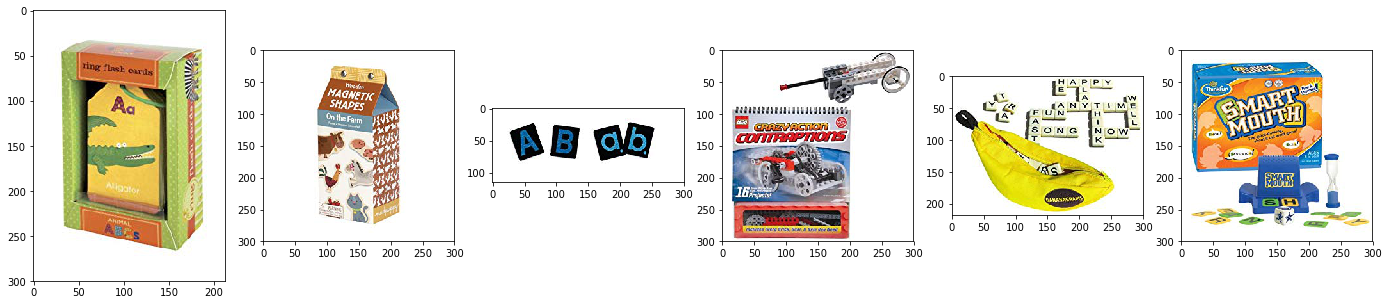

In [26]:
#Find and display similar items using text features
simItemsList = findSimilarsText(userItems)
images = dfMeta[dfMeta['asin'].isin(simItemsList)]['imUrl'].to_list()
showImages(images)
dfMeta[dfMeta['asin'].isin(simItemsList)]

,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
39246,B000F4ABNC,,WOW Harry Copter's Animal Rescue - Holiday &am...,26.67,{'Toys & Games': 48103},http://ecx.images-amazon.com/images/I/41KJUX3M...,WOW,"[[Toys & Games, Toy Remote Control & Play Vehi...","{'also_bought': ['B000F4ABN2', 'B000F44PGQ', '...",Toy Remote Control & Play Vehicles
197430,B004R2DS9C,LEGO&#xAE; Star Wars&#x2122; ZipBin&#xAE; Toy ...,Neat-Oh! LEGO Star Wars ZipBin 1000 Brick Stor...,14.30,{'Toys & Games': 8980},http://ecx.images-amazon.com/images/I/51sC7tBC...,Neat-Oh,"[[Toys & Games, Toy Remote Control & Play Vehi...","{'also_bought': ['B004PAHZMC', 'B0039R8XF0', '...",Toy Remote Control & Play Vehicles
205707,B004Z4BZV0,Shop 'til you drop. This cash register lets gi...,Barbie Shopping Spree Cash Register,49.95,{'Toys & Games': 19861},http://ecx.images-amazon.com/images/I/51PC90Ar...,Barbie,"[[Toys & Games, Electronics for Kids, Electron...","{'also_bought': ['B0076TVUUC', 'B004Z4BZA6', '...",Electronics for Kids
256991,B0085UA8ZE,The Learn N Pop Lion toy helps introduce your ...,Playskool Poppin' Park Learn 'N Pop Lion Toy,9.26,{'Toys & Games': 148632},http://ecx.images-amazon.com/images/I/412g370v...,Playskool,"[[Toys & Games, Novelty & Gag Toys]]","{'also_bought': ['B0085UA7V4', 'B008HYGFJG', '...",Novelty & Gag Toys
278001,B009VSNN74,Time to dust off your Furbish dictionary becau...,Furby (Orange/Blue),47.95,{'Toys & Games': 68576},http://ecx.images-amazon.com/images/I/41g-j2bz...,Furby,"[[Toys & Games, Electronics for Kids, Electron...","{'also_bought': ['B00AQ4U74O', 'B00AMKLVSI', '...",Electronics for Kids
318571,B00F6N0MB8,"Welcome to Puppy's home, full of learning and ...",Fisher-Price Laugh and Learn Puppy's Activity ...,21.61,{'Toys & Games': 13891},http://ecx.images-amazon.com/images/I/41tmE7xH...,Fisher-Price,"[[Toys & Games, Baby & Toddler Toys]]","{'also_bought': ['B00F6N0MM2', 'B00F6N0M8G', '...",Baby & Toddler Toys


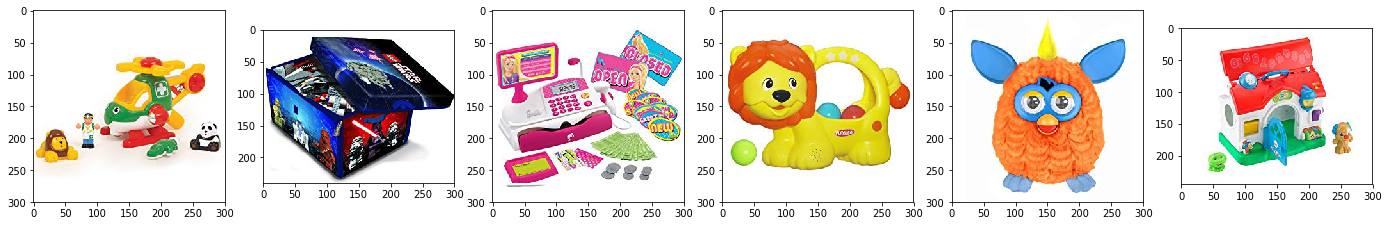

In [28]:
#Find and display similar items using MF
simItemsListMF = findSimilarsMF(userItems)
images = dfMeta[dfMeta['asin'].isin(simItemsListMF)]['imUrl'].to_list()
showImages(images)
dfMeta[dfMeta['asin'].isin(simItemsListMF)]